# General imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [3]:
# Load the data
df = pd.read_csv('data.csv')

In [4]:
df.head()

,index,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,LATITUDE,LONGITUDE,YEAR_SOLD,MONTH_SOLD
0,0,1,01 ONE FAMILY HOMES,1,S1,15 Ave D,10009.0,1.0,1.0,826.0,2240.0,1,S1,593362.0,40.720597,-73.978534,2010,4
1,1,1,02 TWO FAMILY HOMES,1,S2,91 Ave D,10009.0,2.0,1.0,994.0,3799.0,1,S2,1320000.0,40.723003,-73.976803,2010,2
2,2,1,03 THREE FAMILY HOMES,1,C0,326 E 4 St,10009.0,3.0,0.0,2204.0,3921.0,1,C0,900000.0,40.721688,-73.979215,2010,12
3,3,1,04 TAX CLASS 1 CONDOS,1C,R6,238 E 4 St,10009.0,1.0,0.0,0.0,0.0,1,R6,3027375.0,40.723304,-73.982980,2010,8
4,4,1,07 RENTALS - WALKUP APARTMENTS,2,C7,11 Ave D,10009.0,16.0,3.0,3419.0,14400.0,2,C7,8000000.0,40.720484,-73.978618,2010,2


In [5]:
# Convert values to numeric
df['ZIP CODE'] = pd.to_numeric(df['ZIP CODE'], errors='coerce')
df['RESIDENTIAL UNITS'] = pd.to_numeric(df['RESIDENTIAL UNITS'], errors='coerce')
df['COMMERCIAL UNITS'] = pd.to_numeric(df['COMMERCIAL UNITS'], errors='coerce')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')

# Label encoding to convert categorical values to numeric
label_encoder = preprocessing.LabelEncoder()
df['NEIGHBORHOOD'] = label_encoder.fit_transform(df['NEIGHBORHOOD'])

In [6]:
# Drop unnecessary columns
df2 = df.drop(['index',
               'BUILDING CLASS CATEGORY',
               'TAX CLASS AT PRESENT', 
               'BUILDING CLASS AT PRESENT', 
               'TAX CLASS AT TIME OF SALE',
               'BUILDING CLASS AT TIME OF SALE',]
               , axis=1)

df2.shape

(311283, 12)

In [7]:
null_values = df2.isna()

pct_null = (null_values.mean() * 100).round(10)

print("Percentage of null values:")
print(pct_null)

Percentage of null values:
NEIGHBORHOOD         0.000000
ADDRESS              0.001285
ZIP CODE             0.000000
RESIDENTIAL UNITS    0.000000
COMMERCIAL UNITS     0.000000
LAND SQUARE FEET     0.000000
GROSS SQUARE FEET    0.000000
SALE PRICE           0.000000
LATITUDE             0.000000
LONGITUDE            0.000000
YEAR_SOLD            0.000000
MONTH_SOLD           0.000000
dtype: float64


In [8]:
print(df2.dtypes)


NEIGHBORHOOD           int64
ADDRESS               object
ZIP CODE             float64
RESIDENTIAL UNITS    float64
COMMERCIAL UNITS     float64
LAND SQUARE FEET     float64
GROSS SQUARE FEET    float64
SALE PRICE           float64
LATITUDE             float64
LONGITUDE            float64
YEAR_SOLD              int64
MONTH_SOLD             int64
dtype: object


In [9]:
# Contar o número de NaN por coluna
print(df2.isna().sum())

NEIGHBORHOOD         0
ADDRESS              4
ZIP CODE             0
RESIDENTIAL UNITS    0
COMMERCIAL UNITS     0
LAND SQUARE FEET     0
GROSS SQUARE FEET    0
SALE PRICE           0
LATITUDE             0
LONGITUDE            0
YEAR_SOLD            0
MONTH_SOLD           0
dtype: int64


In [10]:
df2.describe()

,NEIGHBORHOOD,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,SALE PRICE,LATITUDE,LONGITUDE,YEAR_SOLD,MONTH_SOLD
count,311283.000000,3.112830e+05,311283.000000,311283.000000,311283.000000,311283.000000,3.112830e+05,311283.000000,311283.000000,311283.000000,311283.000000
mean,45.548549,1.133051e+04,1.785372,0.347227,797.793224,6387.181835,2.282422e+06,40.763669,-73.976123,2010.510025,6.589380
std,20.993594,3.601436e+05,13.351147,4.000125,3591.966286,27904.025884,9.621848e+06,0.030204,0.019610,4.952774,3.356937
min,0.000000,2.780000e+03,0.000000,0.000000,0.000000,0.000000,1.000000e+00,40.527504,-74.215629,2003.000000,1.000000
25%,24.000000,1.001400e+04,0.000000,0.000000,0.000000,0.000000,3.750000e+05,40.743889,-73.987985,2006.000000,4.000000
50%,49.000000,1.002100e+04,0.000000,0.000000,0.000000,0.000000,7.490000e+05,40.764369,-73.978825,2010.000000,7.000000
75%,63.000000,1.002700e+04,1.000000,0.000000,0.000000,0.000000,1.625000e+06,40.778057,-73.962119,2015.000000,9.000000
max,76.000000,1.012848e+08,764.000000,570.000000,149560.000000,420000.000000,3.000000e+08,42.671508,-73.003462,2023.000000,12.000000


In [8]:
# Because we added latitude and longitude information with a Geocoding API, we filter evidently wrong coordinates
from shapely.geometry import Point, Polygon

# These coordinates form a polygon that approximates Manhattan's shape
MANHATTAN_CORDS = [
    (40.698005, -74.016173),
    (40.704772, -74.021498),
    (40.756209, -74.012266),
    (40.878978, -73.929209),
    (40.875195, -73.918612),
    (40.872910, -73.909668),
    (40.863531, -73.914005),
    (40.846438, -73.927714),
    (40.834556, -73.934069),
    (40.808835, -73.933640),
    (40.800519, -73.927370),
    (40.792851, -73.929260),
    (40.781284, -73.940080),
    (40.775369, -73.940080),
    (40.741822, -73.970742),
    (40.728637, -73.964892),
    (40.710145, -73.975104),
    (40.705981, -73.997177),
    (40.699799, -74.004993),
    (40.698005, -74.016173)  # Back to start
]

CENTRAL_PARK_CORDS = [
    (40.768234, -73.981008),
    (40.800278, -73.958016),
    (40.796762, -73.949710),
    (40.765106, -73.973197),
    (40.768234, -73.981008)  # Back to start
]

# Create polygons
MANHATTAN_POLY = Polygon(MANHATTAN_CORDS)
CENTRAL_PARK_POLY = Polygon(CENTRAL_PARK_CORDS)

def FilterManhattanCoordinates(df):
    # Create a mask for points within Manhattan
    def IsInManhattan(row):
        point = Point(row['LATITUDE'], row['LONGITUDE'])
        return MANHATTAN_POLY.contains(point) and not CENTRAL_PARK_POLY.contains(point) # It needs to be inside Manhattan but outside Central Park

    # Apply the filter
    manhattan_mask = df.apply(IsInManhattan, axis=1)
    manhattan_df = df[manhattan_mask].copy()

    return manhattan_df

# Filter coordinates outside Manhattan
df3 = FilterManhattanCoordinates(df2)

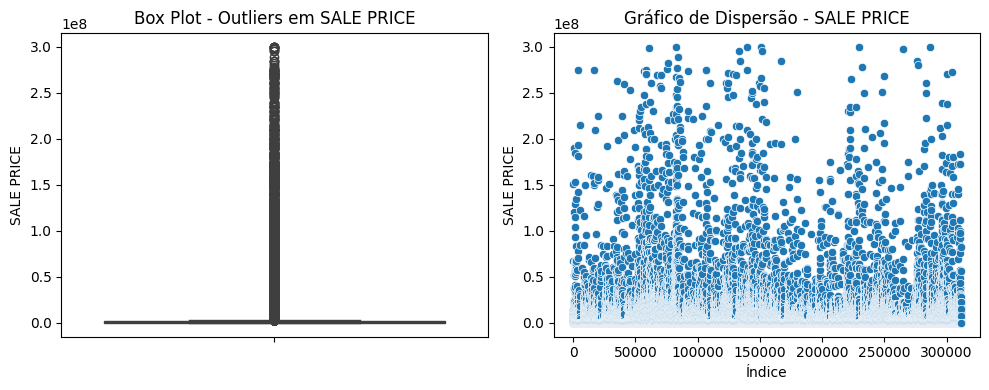

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Box plot
sns.boxplot(y=df3["SALE PRICE"], ax=ax1)
ax1.set_title("Box Plot - Outliers em SALE PRICE")
ax1.set_ylabel("SALE PRICE")

# Scatter plot
sns.scatterplot(x=df3.index, y=df3["SALE PRICE"], ax=ax2)
ax2.set_title("Gráfico de Dispersão - SALE PRICE")
ax2.set_xlabel("Índice")
ax2.set_ylabel("SALE PRICE")

plt.tight_layout()
plt.show()

In [13]:
df3.shape

(309546, 12)

In [14]:
free_properties = df3[df3['SALE PRICE'] <= 10000]
free_properties.shape

(7420, 12)

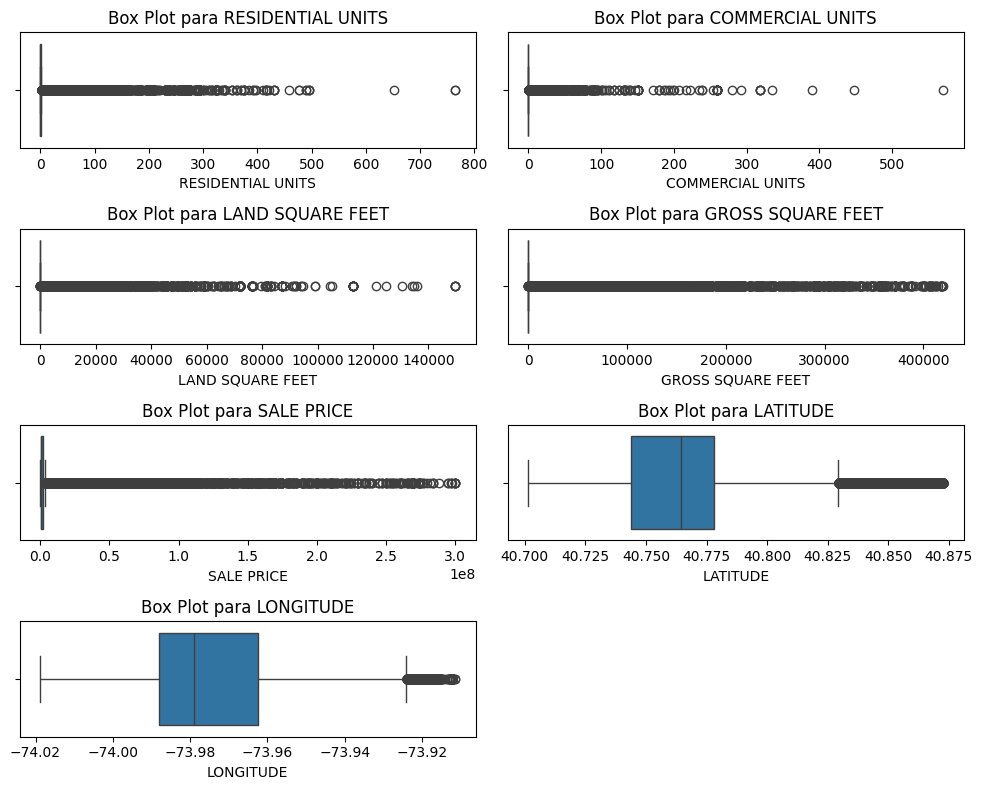

In [15]:
# Selecionar apenas as colunas numéricas
numeric_df = df3.select_dtypes(include=['number'])

numeric_df = numeric_df.drop(columns=['ZIP CODE', 'NEIGHBORHOOD', 'MONTH_SOLD', 'YEAR_SOLD'])

# Definir o número de subplots
num_cols = len(numeric_df.columns)
num_rows = (num_cols + 1) // 2  # Two plots per row
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, 2*num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Criar um box plot para cada coluna numérica
for i, col in enumerate(numeric_df.columns):
    sns.boxplot(x=numeric_df[col], ax=axes[i])
    axes[i].set_title(f'Box Plot para {col}')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [9]:
# Remove outliers
df4 = df3.drop(df[df["LAND SQUARE FEET"] > 120_000].index)
df4 = df3.drop(df[df["COMMERCIAL UNITS"] > 400].index)
df4 = df3.drop(df[df["RESIDENTIAL UNITS"] > 600].index)

In [17]:
# Check for values equal to 0
for col in df4.columns:
    print(f"Valores igual a 0: {col} = {df4[df4[col] == 0].shape[0]}")

Valores igual a 0: NEIGHBORHOOD = 438
Valores igual a 0: ADDRESS = 0
Valores igual a 0: ZIP CODE = 0
Valores igual a 0: RESIDENTIAL UNITS = 175411
Valores igual a 0: COMMERCIAL UNITS = 264737
Valores igual a 0: LAND SQUARE FEET = 270784
Valores igual a 0: GROSS SQUARE FEET = 268566
Valores igual a 0: SALE PRICE = 0
Valores igual a 0: LATITUDE = 0
Valores igual a 0: LONGITUDE = 0
Valores igual a 0: YEAR_SOLD = 0
Valores igual a 0: MONTH_SOLD = 0


In [18]:
# Supondo que o seu DataFrame se chame df
# e que as colunas se chamem exatamente 'LAND SQUARE FEET' e 'GROSS SQUARE FEET'
linhas_zeros = df4[(df4['LAND SQUARE FEET'] == 0) & (df4['GROSS SQUARE FEET'] == 0)].shape[0]

print("Número de linhas onde ambos LAND SQUARE FEET e GROSS SQUARE FEET são 0:", linhas_zeros)


Número de linhas onde ambos LAND SQUARE FEET e GROSS SQUARE FEET são 0: 267336


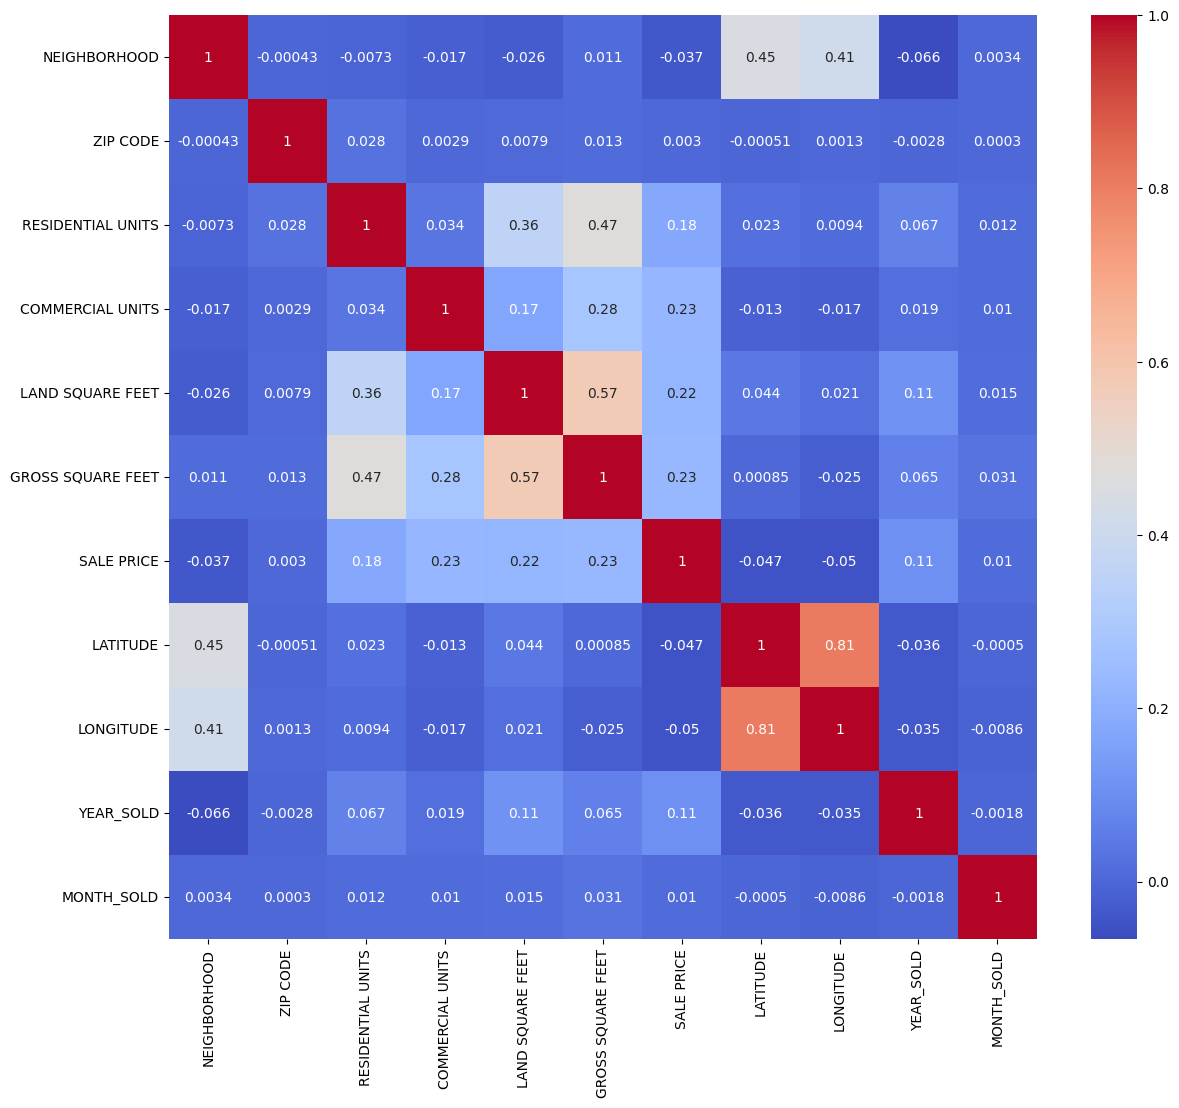

In [19]:
# Calcular a correlação e criar o heatmap
numeric_df = df4.select_dtypes(include=['number'])

plt.figure(figsize=(14, 12))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [30]:
df4.columns


Index(['NEIGHBORHOOD', 'ADDRESS', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'COMMERCIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET',
       'SALE PRICE', 'LATITUDE', 'LONGITUDE', 'YEAR_SOLD', 'MONTH_SOLD'],
      dtype='object')

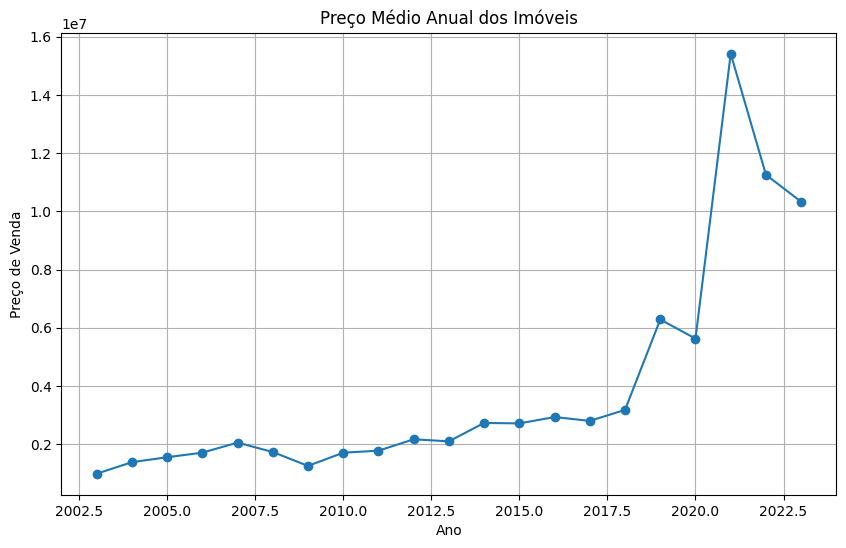

In [21]:
# Group by year and calculate the average sale price
df_ano = df4.groupby(df["YEAR_SOLD"])["SALE PRICE"].mean().reset_index()

# Cria o gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(df_ano["YEAR_SOLD"], df_ano["SALE PRICE"], marker='o', linestyle='-')
plt.title("Preço Médio Anual dos Imóveis")
plt.xlabel("Ano")
plt.ylabel("Preço de Venda")
plt.grid(True)
plt.show()

In [31]:
# Print data frame column types
print(df4.dtypes)

NEIGHBORHOOD           int64
ADDRESS               object
ZIP CODE             float64
RESIDENTIAL UNITS    float64
COMMERCIAL UNITS     float64
LAND SQUARE FEET     float64
GROSS SQUARE FEET    float64
SALE PRICE           float64
LATITUDE             float64
LONGITUDE            float64
YEAR_SOLD              int64
MONTH_SOLD             int64
dtype: object


In [10]:
# Add new columns that reinterpret existing ones

CENTRAL_PARK_CORDS = [
    (40.768234, -73.981008),
    (40.800278, -73.958016),
    (40.796762, -73.949710),
    (40.765106, -73.973197),
    (40.768234, -73.981008)
]
CENTRAL_PARK_POLY = Polygon(CENTRAL_PARK_CORDS)

def DistanceToCentralPark(row):
    point = Point(row['LATITUDE'], row['LONGITUDE'])
    return CENTRAL_PARK_POLY.distance(point)

TIMES_SQUARE = Point(40.757954, -73.985546)

def DistanceToTimesSquare(row):
    point = Point(row['LATITUDE'], row['LONGITUDE'])
    return TIMES_SQUARE.distance(point)

def SeasonOfSale(row):
    month = row['MONTH_SOLD']
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    else:
        return 4

def EnhanceFeatures(df):
    df = df.copy()

    df['DISTANCE TO CENTRAL PARK'] = df.apply(DistanceToCentralPark, axis=1)
    df['DISTANCE TO TIMES SQUARE'] = df.apply(DistanceToTimesSquare, axis=1)
    df['SEASON OF SALE'] = df.apply(SeasonOfSale, axis=1)
    df['PRICE PER SQUARE FOOT'] = np.where(
        df['GROSS SQUARE FEET'] > 0,
        df['SALE PRICE'] / df['GROSS SQUARE FEET'],
        0
    )
    df['TOTAL UNITS'] = df['RESIDENTIAL UNITS'] + df['COMMERCIAL UNITS']
    df['FLOOR AREA RATIO'] = np.where(
        df['LAND SQUARE FEET'] > 0,
        df['GROSS SQUARE FEET'] / df['LAND SQUARE FEET'],
        0
    )
    return df

df5 = EnhanceFeatures(df4)

In [11]:
# Prepare data for training
from sklearn.preprocessing import RobustScaler

# Select features
X = df5.drop(columns=['SALE PRICE', 'ADDRESS', 'NEIGHBORHOOD'])
Y = df5['SALE PRICE']

X_clean = X
Y_clean = Y

# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled = pd.DataFrame(X_scaled, columns=X_clean.columns)


Training Bagging Regressor...
name: Bagging Regressor
RMSE: 1.0851798757187479
R2: 0.7058878132084452
MAE: 0.4934715383558035
CV_mean: 0.6354696450594387
CV_std: 0.046097088763467374

Training Random Forest...
name: Random Forest
RMSE: 1.0848287288969167
R2: 0.7060781223961552
MAE: 0.5344914422826332
CV_mean: 0.6629580944909421
CV_std: 0.04044139131017895

Training XGBoost...
name: XGBoost
RMSE: 1.0527117425308337
R2: 0.7232239594156289
MAE: 0.5123471419687059
CV_mean: 0.6821222666570851
CV_std: 0.0318189737678716

Training CatBoost...
name: CatBoost
RMSE: 1.1119028531860766
R2: 0.6912242061863396
MAE: 0.5741838110025028
CV_mean: 0.6634793473451083
CV_std: 0.037297046957960954

Training Extra Trees...
name: Extra Trees
RMSE: 1.1285726118649138
R2: 0.6818964096851703
MAE: 0.5796247026833438
CV_mean: 0.6422503370064779
CV_std: 0.03317600588239802

Model Comparison:
--------------------------------------------------------------------------------
Model                      RMSE         R2

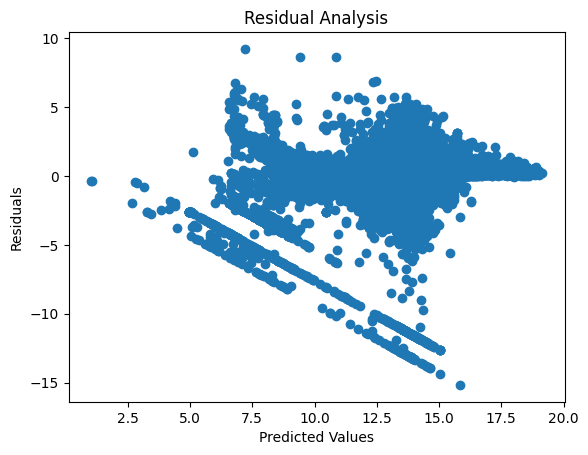

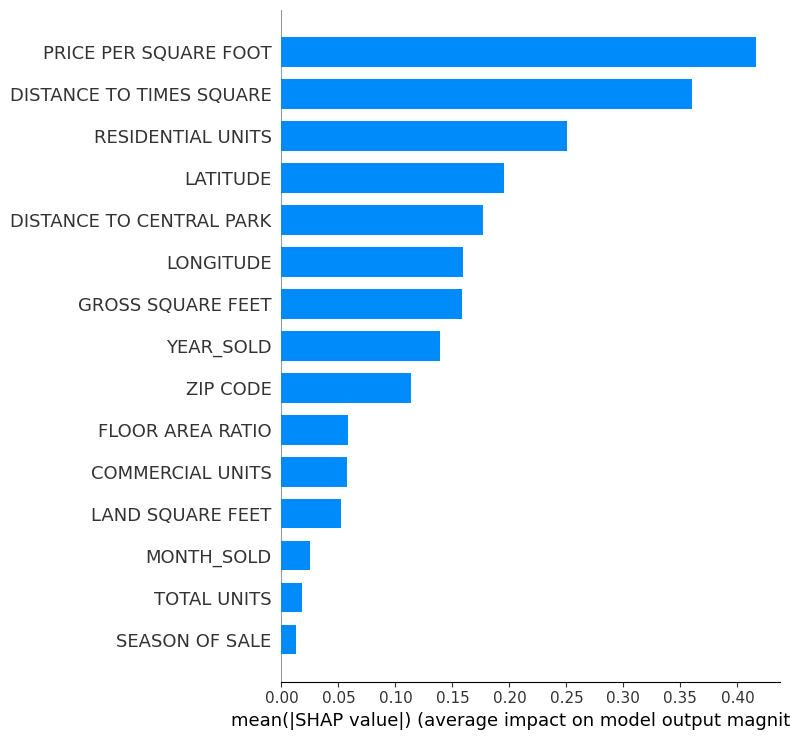

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import mstats
import matplotlib.pyplot as plt
import shap

# Carregar dados (substitua df5 pelo seu DataFrame)
# df5 = pd.read_csv('seu_arquivo.csv')

# Selecionar features
X = df5.drop(columns=['SALE PRICE', 'ADDRESS', 'NEIGHBORHOOD'])
y = df5['SALE PRICE']

# Função para aprimorar features
def enhance_features(X):
    X_new = X.copy()
    # Log transform area features
    X_new['LOG_GROSS_SQFT'] = np.log1p(X_new['GROSS SQUARE FEET'])
    X_new['LOG_LAND_SQFT'] = np.log1p(X_new['LAND SQUARE FEET'])
    # Unit features
    X_new['TOTAL_UNITS'] = X_new['RESIDENTIAL UNITS'] + X_new['COMMERCIAL UNITS']
    X_new['LOG_TOTAL_UNITS'] = np.log1p(X_new['TOTAL_UNITS'])
    # Density metrics
    X_new['UNITS_PER_SQFT'] = X_new['TOTAL_UNITS'] / (X_new['GROSS SQUARE FEET'] + 1)
    X_new['LAND_TO_GROSS_RATIO'] = X_new['LAND SQUARE FEET'] / (X_new['GROSS SQUARE FEET'] + 1)
    # Location features
    X_new['DISTANCE_TO_CENTER'] = np.sqrt(
        (X_new['LATITUDE'] - X_new['LATITUDE'].mean())**2 + 
        (X_new['LONGITUDE'] - X_new['LONGITUDE'].mean())**2
    )
    # Time features
    X_new['SEASON'] = np.sin(2 * np.pi * X_new['MONTH_SOLD'] / 12)
    # Commercial density
    X_new['COMMERCIAL_RATIO'] = X_new['COMMERCIAL UNITS'] / (X_new['TOTAL_UNITS'] + 1)
    return X_new

# Função para remover outliers
def remove_outliers(df, target, columns, n_std=3):
    df_clean = df.copy()
    y_clean = target.copy()
    # Winsorize target
    y_clean = mstats.winsorize(y_clean, limits=[0.05, 0.05])
    # Winsorize features
    for col in columns:
        df_clean[col] = mstats.winsorize(df_clean[col], limits=[0.05, 0.05])
    return df_clean, y_clean

# Transformação da target
y = np.log1p(y)

# Preparar features
X_engineered = X#enhance_features(X)

# Definir colunas para tratamento de outliers
outlier_columns = ['GROSS SQUARE FEET', 'LAND SQUARE FEET', 'TOTAL_UNITS', 'UNITS_PER_SQFT', 'LAND_TO_GROSS_RATIO']

# Remover outliers
X_clean, y_clean = X_engineered, y#remove_outliers(X_engineered, y, outlier_columns)

# Escalar features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled = pd.DataFrame(X_scaled, columns=X_clean.columns)

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_clean, test_size=0.2, random_state=42)

# Definir modelos
models = {
    'Bagging Regressor': BaggingRegressor(
        n_estimators=500,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=500,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBRegressor(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    'CatBoost': CatBoostRegressor(
        iterations=500,
        depth=7,
        learning_rate=0.05,
        #subsample=0.66,
        random_state=42,
        verbose=False,
        task_type='GPU'
    ),
    'Extra Trees': ExtraTreesRegressor(
        n_estimators=500,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
}

# Treinar e avaliar modelos
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    # Treinar modelo
    model.fit(X_train, y_train)
    # Fazer previsões
    y_pred = model.predict(X_test)
    # Calcular métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    # Validação cruzada
    cv_scores = cross_val_score(model, X_scaled, y_clean, cv=5, scoring='r2')
    # Armazenar resultados
    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae,
        'CV_mean': cv_scores.mean(),
        'CV_std': cv_scores.std()
    }
    #print results
    print("name:", name)
    print("RMSE:", rmse)
    print("R2:", r2)
    print("MAE:", mae)
    print("CV_mean:", cv_scores.mean())
    print("CV_std:", cv_scores.std())

# Exibir resultados
print("\nModel Comparison:")
print("-" * 80)
print(f"{'Model':<15} {'RMSE':>15} {'R2':>10} {'MAE':>15} {'CV Mean':>10} {'CV Std':>10}")
print("-" * 80)
for name, metrics in results.items():
    print(f"{name:<15} ${metrics['RMSE']:>14,.2f} {metrics['R2']:>10.4f} ${metrics['MAE']:>14,.2f} {metrics['CV_mean']:>10.4f} {metrics['CV_std']:>10.4f}")

# Melhor modelo
best_model_name = max(results.items(), key=lambda x: x[1]['R2'])[0]
best_model = models[best_model_name]

# Importância das features
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_clean.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(f"\nTop 15 Most Important Features ({best_model_name}):")
    print(feature_importance.head(15))

# Análise de resíduos
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# SHAP Values (interpretabilidade)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class FeaturePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, zero_threshold=0.8):
        self.zero_threshold = zero_threshold
        
    def fit(self, X, y=None):
        # Identify columns with too many zeros
        self.high_zero_cols = []
        for col in X.columns:
            zero_ratio = (X[col] == 0).mean()
            if zero_ratio > self.zero_threshold:
                self.high_zero_cols.append(col)
        return self
    
    def transform(self, X):
        # For columns with too many zeros, replace 0s with NaN
        X_transformed = X.copy()
        for col in self.high_zero_cols:
            X_transformed.loc[X_transformed[col] == 0, col] = np.nan
        return X_transformed

def optimize_bagging_regressor(X, y):
    """
    Optimize BaggingRegressor for real estate price prediction
    
    Parameters:
    X: pd.DataFrame - feature matrix
    y: pd.Series - target variable (SALE PRICE)
    
    Returns:
    tuple: (best_pipeline, cv_results)
    """
    
    # Create pipeline with preprocessing and model
    pipeline = Pipeline([
        ('feature_preprocessor', FeaturePreprocessor(zero_threshold=0.8)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('bagging', BaggingRegressor(random_state=42))
    ])
    
    # Parameter grid for RandomizedSearchCV
    param_grid = {
        'bagging__n_estimators': [100, 200, 500, 1000],
        'bagging__max_samples': [0.5, 0.7, 1.0],
        'bagging__max_features': [0.5, 0.7, 1.0],
        'bagging__bootstrap': [True, False],
        'bagging__bootstrap_features': [True, False],
        'imputer__strategy': ['mean', 'median']
    }
    
    # Configure cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings sampled
        cv=cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,  # Use all available cores
        random_state=42,
        verbose=2
    )
    
    # Fit the random search
    random_search.fit(X, y)
    
    print("Best parameters found:")
    for param, value in random_search.best_params_.items():
        print(f"{param}: {value}")
    
    print("\nBest RMSE:", -random_search.best_score_)
    
    return random_search.best_estimator_, random_search.cv_results_

# Optimize BaggingRegressor
X = df5.drop(columns=['SALE PRICE', 'ADDRESS', 'NEIGHBORHOOD'])
Y = df5['SALE PRICE']
best_pipeline, cv_results = optimize_bagging_regressor(X, Y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits



Training Random Forest...

Training XGBoost...

Training CatBoost...

Training Extra Trees...

Model Comparison:
--------------------------------------------------------------------------------
Model                      RMSE         R2             MAE    CV Mean     CV Std
--------------------------------------------------------------------------------
Random Forest   $  1,752,639.61     0.5509 $    755,626.00     0.4478     0.0437
XGBoost         $  1,758,317.06     0.5479 $    759,572.71     0.4575     0.0375
CatBoost        $  1,881,094.90     0.4826 $    831,123.47     0.4171     0.0366
Extra Trees     $  1,796,223.11     0.5282 $    776,488.31     0.4248     0.0310

Top 15 Most Important Features (Random Forest):
                     feature  importance
5                   LATITUDE    0.127906
9   DISTANCE TO CENTRAL PARK    0.116012
4          GROSS SQUARE FEET    0.114489
10            LOG_GROSS_SQFT    0.108255
6                  LONGITUDE    0.107755
16        DISTANCE_TO_CE

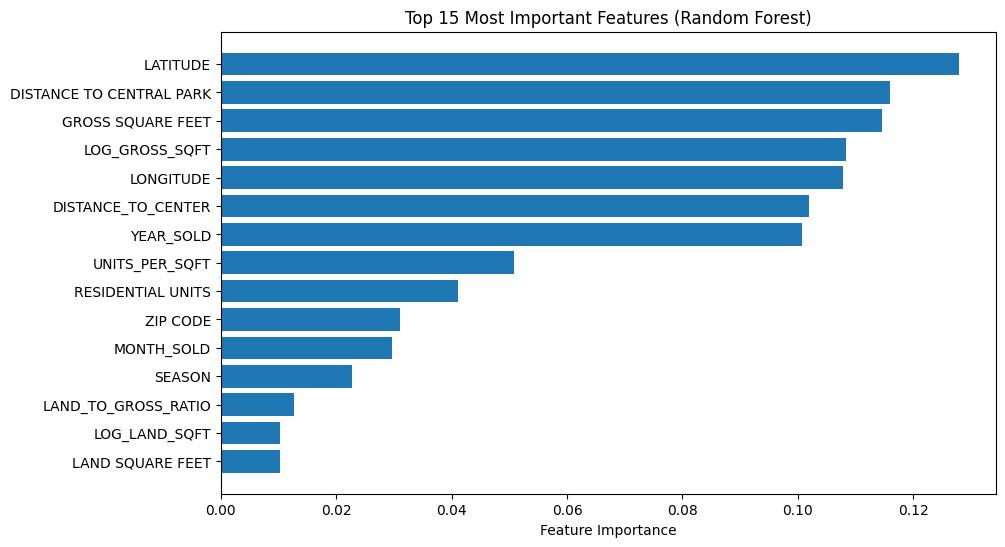

In [ ]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_clean, test_size=0.2, random_state=42)

# Define models
models = {
    'Bagging Regressor': BaggingRegressor(
        n_estimators=500,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=500,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBRegressor(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    'CatBoost': CatBoostRegressor(
        iterations=500,
        depth=7,
        learning_rate=0.05,
        subsample=0.66,
        random_state=42,
        verbose=False
    ),
    'Extra Trees': ExtraTreesRegressor(
        n_estimators=500,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train, Y_train)
    
    # Make predictions
    Y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    r2 = r2_score(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_scaled, Y_clean, cv=5, scoring='r2')
    
    # Store results
    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae,
        'CV_mean': cv_scores.mean(),
        'CV_std': cv_scores.std()
    }

# Print results
print("\nModel Comparison:")
print("-" * 80)
print(f"{'Model':<15} {'RMSE':>15} {'R2':>10} {'MAE':>15} {'CV Mean':>10} {'CV Std':>10}")
print("-" * 80)

for name, metrics in results.items():
    print(f"{name:<15} ${metrics['RMSE']:>14,.2f} {metrics['R2']:>10.4f} ${metrics['MAE']:>14,.2f} {metrics['CV_mean']:>10.4f} {metrics['CV_std']:>10.4f}")

# Get best model
best_model_name = max(results.items(), key=lambda x: x[1]['R2'])[0]
best_model = models[best_model_name]

# Feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_clean.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 15 Most Important Features ({best_model_name}):")
    print(feature_importance.head(15))
print(f"\nTop 15 Most Important Features ({best_model_name}):")
print(feature_importance.head(15))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(15), feature_importance['importance'].head(15))
plt.xlabel('Feature Importance')
plt.title(f'Top 15 Most Important Features ({best_model_name})')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

In [ ]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.ensemble import BaggingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

# Supondo que df4 seja o DataFrame original com os dados
# Select features (excluindo as colunas que não serão utilizadas)
X = df5.drop(columns=['SALE PRICE', 'ADDRESS'])
y = df5['SALE PRICE']

def enhance_features(X):
    X_new = X.copy()
    
    # Log transform em features de área
    X_new['LOG_GROSS_SQFT'] = np.log1p(X_new['GROSS SQUARE FEET'])
    X_new['LOG_LAND_SQFT'] = np.log1p(X_new['LAND SQUARE FEET'])
    
    # Features de unidades
    X_new['TOTAL_UNITS'] = X_new['RESIDENTIAL UNITS'] + X_new['COMMERCIAL UNITS']
    X_new['LOG_TOTAL_UNITS'] = np.log1p(X_new['TOTAL_UNITS'])
    
    # Métricas de densidade
    X_new['UNITS_PER_SQFT'] = X_new['TOTAL_UNITS'] / (X_new['GROSS SQUARE FEET'] + 1)
    X_new['LAND_TO_GROSS_RATIO'] = X_new['LAND SQUARE FEET'] / (X_new['GROSS SQUARE FEET'] + 1)
    
    # Features de localização (distância do centro – usando média como referência)
    X_new['DISTANCE_TO_CENTER'] = np.sqrt(
        (X_new['LATITUDE'] - X_new['LATITUDE'].mean())**2 + 
        (X_new['LONGITUDE'] - X_new['LONGITUDE'].mean())**2
    )
    
    # Features temporais (por exemplo, sazonalidade)
    X_new['SEASON'] = np.sin(2 * np.pi * X_new['MONTH_SOLD'] / 12)
    
    # Densidade comercial
    X_new['COMMERCIAL_RATIO'] = X_new['COMMERCIAL UNITS'] / (X_new['TOTAL_UNITS'] + 1)
    
    return X_new

def remove_outliers(df, target, columns, n_std=3):
    df_clean = df.copy()
    y_clean = target.copy()
    
    # Remove outliers do preço primeiro
    price_mean = y_clean.mean()
    price_std = y_clean.std()
    price_mask = abs(y_clean - price_mean) <= (n_std * price_std)
    df_clean = df_clean[price_mask]
    y_clean = y_clean[price_mask]
    
    # Remove outliers das features especificadas
    for col in columns:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        mask = abs(df_clean[col] - mean) <= (n_std * std)
        df_clean = df_clean[mask]
        y_clean = y_clean[mask]
    
    return df_clean, y_clean

# Prepara as features com engenharia
X_engineered = enhance_features(X)

# Define as colunas que serão usadas para remoção de outliers
outlier_columns = ['GROSS SQUARE FEET', 'LAND SQUARE FEET', 'TOTAL_UNITS', 
                   'UNITS_PER_SQFT', 'LAND_TO_GROSS_RATIO']

# Remove outliers
X_clean, y_clean = remove_outliers(X_engineered, y, outlier_columns)

# Escala as features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled = pd.DataFrame(X_scaled, columns=X_clean.columns)

# Split dos dados
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_clean, test_size=0.2, random_state=42)

########################################
# Modelos adicionais para teste
########################################

# Define os modelos
models_extra = {
    'Bagging Regressor': BaggingRegressor(
        #base_estimator=DecisionTreeRegressor(max_depth=10),
        n_estimators=100,
        random_state=42
    ),
    'Hist Gradient Boosting': HistGradientBoostingRegressor(
        max_iter=500,
        max_depth=7,
        learning_rate=0.05,
        random_state=42
    ),
    'K-Nearest Neighbors': KNeighborsRegressor(
        n_neighbors=10,
        weights='distance'
    ),
    'Decision Tree': DecisionTreeRegressor(
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),
    'MLP Regressor': MLPRegressor(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        alpha=0.01,
        learning_rate='adaptive',
        max_iter=500,
        random_state=42
    ),
    'Bayesian Ridge': BayesianRidge(
        max_iter=300
    ),
    'Huber Regressor': HuberRegressor(
        epsilon=1.35,
        alpha=0.0001
    ),
    'Gaussian Process': GaussianProcessRegressor(
        kernel=ConstantKernel(1.0) * RBF(length_scale=1.0),
        alpha=0.1,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        random_state=42
    ),
    'AdaBoost': AdaBoostRegressor(
        n_estimators=500,
        learning_rate=0.05,
        random_state=42
    ),
    'SVR': SVR(
        kernel='rbf',
        C=1.0,
        epsilon=0.1
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        random_state=42
    ),
    'ElasticNet': ElasticNetCV(
        cv=5,
        random_state=42
    ),
    'Lasso': LassoCV(
        cv=5,
        random_state=42
    )
}

# Treina e avalia os modelos adicionais
results_extra = {}

for name, model in models_extra.items():
    print(f"\nTreinando {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calcula as métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Validação cruzada (cv=5)
    cv_scores = cross_val_score(model, X_scaled, y_clean, cv=5, scoring='r2')
    
    results_extra[name] = {
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae,
        'CV_mean': cv_scores.mean(),
        'CV_std': cv_scores.std()
    }
    
    # Exibe as métricas
    print(f"{name} - RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
    print(f"CV Mean: {cv_scores.mean():.4f}, CV Std: {cv_scores.std():.4f}")

# Exibe os resultados
print("\nComparação dos Modelos Adicionais:")
print("-" * 90)
print(f"{'Modelo':<20} {'RMSE':>15} {'R2':>10} {'MAE':>15} {'CV Mean':>10} {'CV Std':>10}")
print("-" * 90)
for name, metrics in results_extra.items():
    print(f"{name:<20} ${metrics['RMSE']:>14,.2f} {metrics['R2']:>10.4f} ${metrics['MAE']:>14,.2f} {metrics['CV_mean']:>10.4f} {metrics['CV_std']:>10.4f}")


Treinando Bagging Regressor...
Bagging Regressor - RMSE: 1722000.39, R2: 0.5664, MAE: 692423.58
CV Mean: 0.4345, CV Std: 0.0385

Treinando Hist Gradient Boosting...
Hist Gradient Boosting - RMSE: 1814921.26, R2: 0.5184, MAE: 790468.68
CV Mean: 0.4379, CV Std: 0.0399

Treinando K-Nearest Neighbors...
K-Nearest Neighbors - RMSE: 2092129.72, R2: 0.3600, MAE: 871505.90
CV Mean: 0.2420, CV Std: 0.0414

Treinando Decision Tree...
Decision Tree - RMSE: 1942394.31, R2: 0.4483, MAE: 806905.88
CV Mean: 0.2825, CV Std: 0.0531

Treinando MLP Regressor...


c:\Users\ester\Desktop\RestateAI\Real_Estate_AI\RestateAI\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Regressor - RMSE: 2154161.78, R2: 0.3215, MAE: 1000494.05
CV Mean: -959.0606, CV Std: 1918.6203

Treinando Bayesian Ridge...
Bayesian Ridge - RMSE: 2311684.51, R2: 0.2186, MAE: 1139811.48
CV Mean: -12549.6623, CV Std: 25099.0316

Treinando Huber Regressor...


c:\Users\ester\Desktop\RestateAI\Real_Estate_AI\RestateAI\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\ester\Desktop\RestateAI\Real_Estate_AI\RestateAI\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\ester\Desktop\RestateAI\Real_Estate_AI\RestateAI\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed t

Huber Regressor - RMSE: 2441597.62, R2: 0.1283, MAE: 1023975.11
CV Mean: -36.0107, CV Std: 72.2443

Treinando Gaussian Process...


MemoryError: Unable to allocate 389. GiB for an array with shape (228493, 228493) and data type float64

In [25]:
# Check model accuracy

# Para fazer predições com múltiplos dados
varios_dados = pd.DataFrame({ 
    'ZIP CODE': [10022, 10028, 0],
    'RESIDENTIAL UNITS': [1, 1, 0],
    'COMMERCIAL UNITS': [0, 0, 0],
    'LAND SQUARE FEET': [0, 0, 0],
    'GROSS SQUARE FEET': [1600, 5000, 0],
    'LATITUDE': [40.759486, 40.774235, 0],
    'LONGITUDE': [-73.964601, -73.953697, 0],
    'YEAR_SOLD': [2025, 2025, 0],
    'MONTH_SOLD': [1, 1, 0]
})

real_prices = [700_000, 6_250_000, 0]

# Preparar múltiplos dados
varios_dados_preparados = enhance_features(varios_dados)

# Fazer predições múltiplas
precos_previstos = best_model.predict(varios_dados_preparados)

# Mostrar resultados
for i, preco in enumerate(precos_previstos):
    print(f"Propriedade {i+1}: Predicted ${preco:,.2f} | Real ${real_prices[i]:,.2f}")

Propriedade 1: Predicted $2,738,509.67 | Real $700,000.00
Propriedade 2: Predicted $5,291,595.08 | Real $6,250,000.00
Propriedade 3: Predicted $2,822,433.56 | Real $0.00
